## Autocorrelation & Autoregression with Stock Prices

*Adapted by Jeff Hale*

You're interested in the performance of a particular stock. 

Autocorrelation is "correlation between the elements of a series and others from the same series separated from them by a given interval." - OED via Google

You use the [autocorrelation function](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html) in Pandas to assess how autocorrelated the stock's values are.

Here are the stock's values shifted to show lags.

| Day | Price | Price with Lag = 1 | Price with Lag = 2 |
|-----|-------|--------------------|--------------------|
| 1   | 25    | NA                 | NA                 |
| 2   | 26    | 25                 | NA                 |
| 3   | 28    | 26                 | 25                 |
| 4   | 24    | 28                 | 26                 |
| 5   | 23    | 24                 | 28                 |

Autocorrelation with a lag of 1 will calculate the correlation between column "Price" and column "Price with Lag = 1." Autocorrelation with a lag of $k$ will calculate the correlation between stock price and the stock price of $k$ days before in a similar manner.

Suppose I build a loop that iterates through days (we'll assume our stock price is the closing price at every day) 1 to 365 to assess how correlated a stock price is with the stock price from $i$ days ago. (Sample code seen below.)

```
for i in range(1, 366):
    print(df[stock_prices].autocorr(lag=i))
```

#### 1. Suppose my highest values of autocorrelation are found when $i = 1, 7, 30, 365$. What do each of these suggest about the performance of this particular stock?

These numbers tell us a couple of things:
1) The day prior has a correlation with the current day, so the stock price doesn't change very much on a daily basis.
2) The stock follows a cyclical pattern because exactly one week, one month, and one year ago there was a correlation to current day.

Stock prices vary quite rapidly. Looking at almost any plot of stock price over time, we'll see a very "wiggly" function that moves around erratically. Building a model for this can be difficult.

One way to "de-noise" or "smooth" this is to create a [moving average](http://www.investopedia.com/terms/m/movingaverage.asp) of stock prices. Suppose I wanted to create a moving average of stock prices across $k$ days. In this case, I create a new column that takes the current day and $k-1$ previous days (for $k$ total days) and average the stock prices of these days.

For example, I have a column of stock prices and a column associated with a moving average for three days. Then, my row for Day 5 includes the Day 5 stock price and the average of Day 3, Day 4, and Day 5 stock prices. 

| Day | Price | Moving Average k = 3 |
|-----|-------|----------------------|
| 1   | 25    | NA                   |
| 2   | 26    | NA                   |
| 3   | 28    | 26.33                |
| 4   | 24    | 26                   |
| 5   | 23    | 25                   |

#### 2.  As the number of periods $k$ increases, how do I expect my plotted curve's shape to change?

It will be come more smooth with less ups and downs by day.

#### 3. Suppose we use our moving average to predict values of the stock price. As $k$ increases, how is the bias of our predictions affected? 

As k increases the bias of the predictions will increase.

#### 4. As $k$ increases, how is the variance of our predictions affected?

As k increases the variance of the predictions will decrease.

## Stock price exploration 

#### Using the `yfinance` package, download stock data from the past five years for a company you are interested in. 

If needed, `pip install yfinance` 

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



In [2]:
df = yf.download('VGT', start = '2016-01-01')

[*********************100%***********************]  1 of 1 completed


#### Examine the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1358 entries, 2016-01-04 to 2021-05-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1358 non-null   float64
 1   High       1358 non-null   float64
 2   Low        1358 non-null   float64
 3   Close      1358 non-null   float64
 4   Adj Close  1358 non-null   float64
 5   Volume     1358 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 74.3 KB


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,106.309998,106.610001,104.940002,106.610001,100.238541,510600
2016-01-05,106.959999,107.150002,105.750000,106.099998,99.759018,402300
2016-01-06,104.559998,105.370003,103.970001,104.660004,98.405098,655800
2016-01-07,102.519997,103.639999,101.239998,101.290001,95.236496,747200
2016-01-08,102.199997,102.500000,100.260002,100.419998,94.418488,458600


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-19,353.059998,360.420013,352.700012,360.269989,360.269989,336000
2021-05-20,361.779999,368.609985,361.579987,367.399994,367.399994,312300
2021-05-21,369.440002,370.100006,365.339996,365.640015,365.640015,272200
2021-05-24,368.570007,373.320007,368.529999,372.000000,372.000000,738700
2021-05-25,373.690002,374.369995,371.354004,372.119995,372.119995,267193


#### We'll be working with the 'Adj Close' column. Rename that column 'price' and make your DataFrame just that column and the datetime index. 

In [6]:
df.rename(columns = {'Adj Close': 'price'}, inplace=True)

In [7]:
df_price = df[['price']]
df_price.head()

,price
Date,
2016-01-04,100.238541
2016-01-05,99.759018
2016-01-06,98.405098
2016-01-07,95.236496
2016-01-08,94.418488


#### Add columns that are lags of the most recent 10 observations.

In [8]:
lag_features = {i: f'lag_{i}' for i in range(1, 11)}
lag_features

{1: 'lag_1',
 2: 'lag_2',
 3: 'lag_3',
 4: 'lag_4',
 5: 'lag_5',
 6: 'lag_6',
 7: 'lag_7',
 8: 'lag_8',
 9: 'lag_9',
 10: 'lag_10'}

In [9]:
df_lags = df_price.copy()

In [10]:
for i, column_name in lag_features.items():
    df_lags[column_name] = df_lags['price'].shift(i)
    
df_lags

,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,
2016-01-04,100.238541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,99.759018,100.238541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,98.405098,99.759018,100.238541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,95.236496,98.405098,99.759018,100.238541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,94.418488,95.236496,98.405098,99.759018,100.238541,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-19,360.269989,359.010010,361.380005,364.119995,355.880005,351.880005,362.549988,362.869995,372.500000,368.959991,366.720001
2021-05-20,367.399994,360.269989,359.010010,361.380005,364.119995,355.880005,351.880005,362.549988,362.869995,372.500000,368.959991
2021-05-21,365.640015,367.399994,360.269989,359.010010,361.380005,364.119995,355.880005,351.880005,362.549988,362.869995,372.500000


#### Split the DataFrame into training and test sets so that the test set is the most recent year of data (you can use pandas slicing, scikit-learn, or sktime packages to do this).

In [11]:
train = df_price.loc[:'2019']
train.head(2)

,price
Date,
2016-01-04,100.238541
2016-01-05,99.759018


In [12]:
train.tail(2)

,price
Date,
2019-12-30,241.152298
2019-12-31,241.814011


In [13]:
test = df_price.loc['2020']
test.head(2)

,price
Date,
2020-01-02,246.248322
2020-01-03,243.660812


In [14]:
test.tail(2)

,price
Date,
2020-12-30,352.844543
2020-12-31,353.153992


#### Plot the stock price with different colors for the training and test sets.

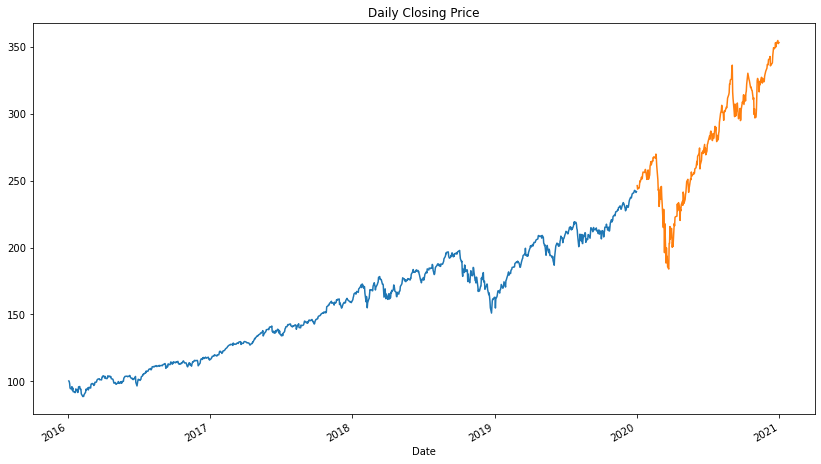

In [15]:
train['price'].plot()
test['price'].plot(figsize = (14, 8), title = 'Daily Closing Price');

#### Find the autocorrelations of the training data for lags 1-10.

In [16]:
for i in range(11):
    print(df_price['price'].autocorr(i))

1.0
0.9990612128628984
0.9984903996491402
0.9977593654841405
0.9970041132100841
0.9963193278399148
0.9955924077518503
0.9951148145914306
0.994359986040618
0.9938655771722165
0.9930631369840874


#### Plot the autocorrelation using statsmodels `plot_acf`.

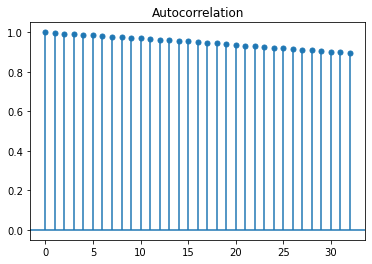

In [17]:
plot_acf(df_price['price'], alpha=None);

#### Plot the partial autocorrelation values using statsmodels `plot_pacf`.

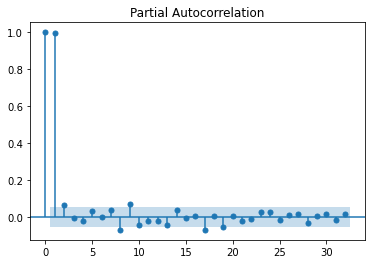

In [18]:
plot_pacf(df_price['price']);

#### Do any lags have high autocorrelation?

Yes, they all seem to be highly correlated, but after the first day back, the lags don't give us much new information.

### Baseline model

#### Make a baseline model that is just the last value from the training set, continued into the future.

In [19]:
df_predictions = test.copy(deep = True)
df_predictions.head(2)

,price
Date,
2020-01-02,246.248322
2020-01-03,243.660812


In [20]:
df_predictions['last'] = train['price'].iloc[-1]
df_predictions

,price,last
Date,,
2020-01-02,246.248322,241.814011
2020-01-03,243.660812,241.814011
2020-01-06,244.470642,241.814011
2020-01-07,244.441010,241.814011
2020-01-08,247.018661,241.814011
...,...,...
2020-12-24,352.245605,241.814011
2020-12-28,354.721130,241.814011
2020-12-29,352.375397,241.814011


#### Plot it

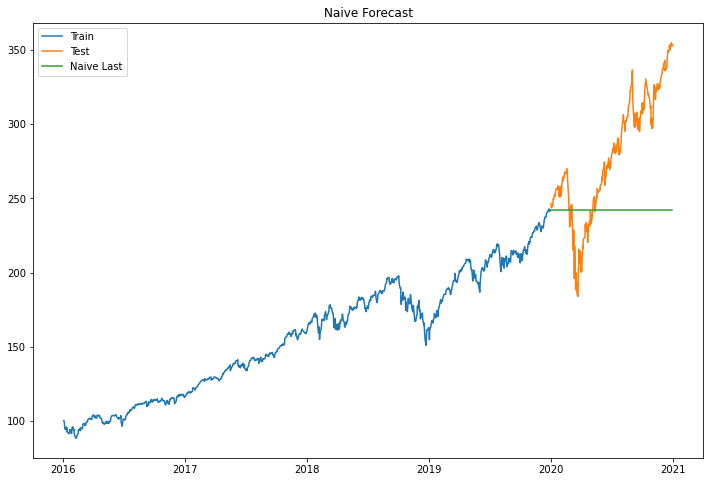

In [21]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index, test['price'], label='Test')
plt.plot(df_predictions.index, df_predictions['last'], label="Naive Last")

plt.legend(loc='best')
plt.title("Naive Forecast");

#### Score it on the test set using MAE

In [22]:
round(mean_squared_error(df_predictions['price'], df_predictions['last'], squared = False),2)

55.46

## Autoregression model
"Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step." - [Machine Learning Mastery](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

#### Using scikit-learn's LinearRegression class, make a model to predict the stock price based on 10 lags. 

In [23]:
df_lags.dropna(inplace=True)

In [24]:
X = df_lags.drop(columns = 'price')
y = df_lags['price']

In [25]:
X.head(2)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,
2016-01-19,92.237129,95.067245,93.271385,95.960464,94.879219,94.418488,95.236496,98.405098,99.759018,100.238541
2016-01-20,91.992661,92.237129,95.067245,93.271385,95.960464,94.879219,94.418488,95.236496,98.405098,99.759018


In [26]:
y.head(2)

Date
2016-01-19    91.992661
2016-01-20    91.503746
Name: price, dtype: float64

In [27]:
X_train = X.loc[:'2019']
X_test = X.loc['2020']
y_train = y.loc[:'2019']
y_test = y.loc['2020']

In [28]:
X_train.head(2)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,
2016-01-19,92.237129,95.067245,93.271385,95.960464,94.879219,94.418488,95.236496,98.405098,99.759018,100.238541
2016-01-20,91.992661,92.237129,95.067245,93.271385,95.960464,94.879219,94.418488,95.236496,98.405098,99.759018


In [29]:
X_test.head(2)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,
2020-01-02,241.814011,241.152298,242.594208,242.683090,240.826401,240.806656,239.996796,238.663544,237.103134,237.024139
2020-01-03,246.248322,241.814011,241.152298,242.594208,242.683090,240.826401,240.806656,239.996796,238.663544,237.103134


In [30]:
y_train.head(2)

Date
2016-01-19    91.992661
2016-01-20    91.503746
Name: price, dtype: float64

In [31]:
y_test.head(2)

Date
2020-01-02    246.248322
2020-01-03    243.660812
Name: price, dtype: float64

#### Create and fit your model.

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Predict on the test set, plot, and score on MAE.

In [33]:
preds = lr.predict(X_test)
preds

array([241.95270836, 245.99095863, 243.61522082, 245.17887837,
       244.15073716, 246.89383751, 249.92123812, 249.673665  ,
       251.99944188, 251.4167112 , 251.61821778, 254.98296587,
       256.15095897, 255.92485439, 257.5831434 , 257.7477933 ,
       257.29744092, 251.73537678, 255.70875977, 255.32390685,
       258.58012324, 251.55864309, 254.44256125, 259.75649492,
       263.02369036, 264.11338611, 261.8425289 , 264.09018614,
       265.17496654, 267.66190208, 266.1065644 , 268.0672292 ,
       266.44968979, 270.44291672, 266.9416899 , 262.4266093 ,
       251.29309885, 243.9235781 , 243.6629155 , 232.08607026,
       234.0118478 , 244.3172494 , 236.07058186, 247.52105282,
       238.19846472, 232.8034097 , 217.49700817, 229.91040485,
       214.85607473, 201.19929792, 216.89628183, 188.02151605,
       202.23033234, 195.26357601, 192.20750398, 185.92199486,
       189.02344501, 197.49065655, 206.39964275, 214.57340556,
       206.31715212, 213.75261633, 209.58295271, 202.81

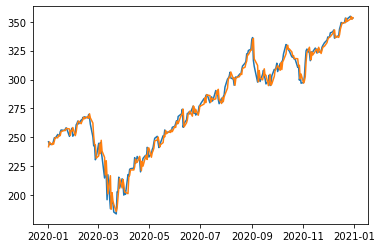

In [34]:
plt.plot(X_test.index, y_test);
plt.plot(X_test.index, preds);

In [35]:
round(mean_squared_error(y_test, preds, squared = False),2)

5.82

#### How does this very basic model perform?

It performs pretty well.

#### How does it compare to the baseline?

Definitely an improvement from the baseline.

#### Congratulations! You just made an autoregression model (AR)! 🎉

#### Would your recommend anyone use your model to guide their investment decisions?

The model looks like it performs pretty well, but I'd err on the side of caution because stocks can be very unpredictable.